In [191]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss,MAE, MAPE,SMAPE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.models import Autoformer, GRU, LSTM, MLP, TCN, VanillaTransformer,Informer
from neuralforecast.auto import AutoTFT
from neuralforecast.core import _future_dates

In [192]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [193]:
ticker='GOOGL'

In [194]:
#Rename columns date to ds, close to y, and ticker_symbol to unique_id
df = df.rename(columns={'Date':'ds','Close':'y','ticker_symbol':'unique_id'})
#set unique_id,ds and y as the first columns
df1 = df[['unique_id','ds','y','p_sentiment', 'Open', 'High', 'Low', 'unrate',
       'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro',
       'ccpi']]
#only the unique_id==TSLA
exogen_cols=['p_sentiment', 'Open', 'High', 'Low', 'unrate',
       'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro',
       'ccpi']
df1['ds'] = pd.to_datetime(df1['ds'])
df2 = df1[df1['unique_id']==ticker]
#sort by date 
df2 = df2.sort_values(by='ds')
#add a column with the index values
df2['idx'] = range(0, len(df2))
#set the idx column as the new ds
df2['ds'] = df2['idx']
#drop the idx column
df2 = df2.drop(['idx'], axis=1)




In [195]:
horizon = 30

In [196]:
Y_train_df = df2[df2.ds<df2['ds'].values[-horizon]] # 132 train
Y_test_df = df2[df2.ds>=df2['ds'].values[-horizon]].reset_index(drop=True) # 12 test

In [197]:
#shapes
print(Y_train_df.shape)
print(Y_test_df.shape)

(1227, 18)
(30, 18)


In [198]:
Y_train_df['unique_id'].unique()

array(['GOOGL'], dtype=object)

In [199]:
model1 = VanillaTransformer(h=horizon,
                 input_size=10,
                 hidden_size = 32,
                 conv_hidden_size = 64,
                 n_head=2,
                 encoder_layers=2,
                 loss=SMAPE(),
                 futr_exog_list=exogen_cols,
                 scaler_type='minmax',
                 learning_rate=5e-4,
                 decoder_layers=2,
                 max_steps=1000,
                 val_check_steps=50,
                 early_stop_patience_steps=5)

model2= TCN(h=horizon,
                input_size=-1,
                loss=SMAPE(),
                learning_rate=5e-4,
                kernel_size=10,
                dilations=[1,2,4,8,16],
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=500,
                scaler_type='minmax',
                futr_exog_list=exogen_cols,
                )

model3 = Informer(h=horizon,
                 input_size=10,
                 hidden_size = 32,
                 conv_hidden_size = 64,
                 encoder_layers=2,
                 n_head=2,
                 loss=SMAPE(),
                 futr_exog_list=exogen_cols,
                 scaler_type='minmax',
                 learning_rate=5e-4,
                 max_steps=1000,
                 decoder_layers=2,
                 val_check_steps=50,
                 early_stop_patience_steps=5)

model4 = Autoformer(h=horizon,
                 input_size=10,
                 hidden_size = 32,
                 conv_hidden_size = 64,
                 encoder_layers=2,
                 n_head=4,
                 loss=SMAPE(),
                 futr_exog_list=exogen_cols,
                 scaler_type='minmax',
                 learning_rate=5e-4,
                 max_steps=1000,
                 val_check_steps=50,
                 decoder_layers=2,
                 early_stop_patience_steps=5)

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [200]:
#show last row of Y_train_df
Y_train_df

,unique_id,ds,y,p_sentiment,Open,High,Low,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
3,GOOGL,0,26.477501,0.908735,26.629999,26.790001,26.393999,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
9,GOOGL,1,25.973000,0.882317,26.357500,26.399500,25.887501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
15,GOOGL,2,25.332001,0.791379,26.025000,26.060499,25.277500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
21,GOOGL,3,25.257500,0.721880,25.547501,25.574499,25.182501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
27,GOOGL,4,25.345501,0.730047,25.075500,25.375000,24.750999,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7330,GOOGL,1222,65.449997,0.735473,65.075996,65.855499,65.075996,3.6,7.5,15258.0,14885.9,14667.6,117.41,1.812105,1.553333,1450239.0,101.9876,265.427
7336,GOOGL,1223,64.914001,0.711779,65.199997,65.245003,64.793503,3.6,7.5,15258.0,14885.9,14667.6,117.41,1.812105,1.553333,1450239.0,101.9876,265.427
7342,GOOGL,1224,64.860497,0.711531,64.928497,65.467499,64.711998,3.6,7.5,15258.0,14885.9,14667.6,117.41,1.812105,1.553333,1450239.0,101.9876,265.427
7348,GOOGL,1225,64.808998,0.731655,64.658997,65.125999,64.607498,3.6,7.5,15258.0,14885.9,14667.6,117.41,1.812105,1.553333,1450239.0,101.9876,265.427


In [201]:

nf = NeuralForecast(
    models=[model1, model2, model3, model4],
    freq='D'
)
nf.fit(df=Y_train_df, val_size=horizon)
expected_futr_df = _future_dates(nf.dataset, nf.uids, nf.last_dates, nf.freq, nf.h)
print(expected_futr_df)

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 30.06it/s, v_num=189, train_loss_step=1.480]

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s, v_num=192, train_loss_step=0.870, train_loss_epoch=0.870, valid_loss=0.0154]
             ds
unique_id      
GOOGL      1227
GOOGL      1228
GOOGL      1229
GOOGL      1230
GOOGL      1231
GOOGL      1232
GOOGL      1233
GOOGL      1234
GOOGL      1235
GOOGL      1236
GOOGL      1237
GOOGL      1238
GOOGL      1239
GOOGL      1240
GOOGL      1241
GOOGL      1242
GOOGL      1243
GOOGL      1244
GOOGL      1245
GOOGL      1246
GOOGL      1247
GOOGL      1248
GOOGL      1249
GOOGL      1250
GOOGL      1251
GOOGL      1252
GOOGL      1253
GOOGL      1254
GOOGL      1255
GOOGL      1256


In [202]:
Y_test_df.shape

(30, 18)

In [203]:
forecasts = nf.predict(futr_df=Y_test_df)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.55it/s]


inf
inf
inf
inf
0.6716298878417969
0.4067933340332033
0.834899462288411
0.8744377593424478


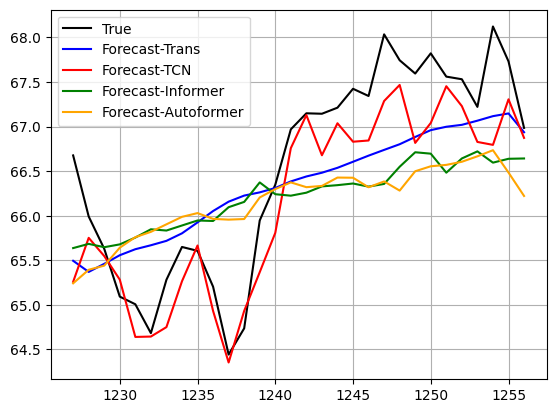

In [204]:
from sklearn.metrics import mean_absolute_error
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
#Mean Absolute Scaled Error
def MASE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(y_true[1:] - y_true[:-1]))
print(MASE(Y_test_df['y'], Y_hat_df['VanillaTransformer']))
print(MASE(Y_test_df['y'], Y_hat_df['TCN']))
print(MASE(Y_test_df['y'], Y_hat_df['Informer']))
print(MASE(Y_test_df['y'], Y_hat_df['Autoformer']))



#MAE between Y_test_df and Y_hat_df
print(mean_absolute_error(Y_test_df['y'], Y_hat_df['VanillaTransformer']))
print(mean_absolute_error(Y_test_df['y'], Y_hat_df['TCN']))

print(mean_absolute_error(Y_test_df['y'], Y_hat_df['Informer']))
print(mean_absolute_error(Y_test_df['y'], Y_hat_df['Autoformer']))
plot_df = pd.concat([Y_test_df,Y_hat_df], axis=1)
#plot_df = pd.concat([Y_train_df, plot_df])


plot_df = plot_df[plot_df.unique_id==ticker].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['VanillaTransformer'], c='blue', label='Forecast-Trans')
plt.plot(plot_df['ds'], plot_df['TCN'], c='Red', label='Forecast-TCN')
plt.plot(plot_df['ds'], plot_df['Informer'], c='Green', label='Forecast-Informer')
plt.plot(plot_df['ds'], plot_df['Autoformer'], c='Orange', label='Forecast-Autoformer')

plt.legend()
plt.grid()

In [205]:
from sklearn.metrics import mean_absolute_error

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
#MAE between Y_test_df and Y_hat_df
print(mean_absolute_error(Y_test_df['y'], Y_hat_df[' TCN']))
plot_df = pd.concat([Y_test_df,Y_hat_df], axis=1)
#plot_df = pd.concat([Y_train_df, plot_df])


plot_df = plot_df[plot_df.unique_id=='TSLA'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TCN'], c='blue', label='Forecast')
plt.legend()
plt.grid()

KeyError: ' TCN'

In [ ]:
#show tensorboard graphs
%load_ext tensorboard
%tensorboard --logdir lightning_logs/



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3291), started 0:03:01 ago. (Use '!kill 3291' to kill it.)